In [1]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [2]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\02_autoencoder

c:\workspace\autoencoder\03_ELECTRIC-ENGINE


In [3]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\02_autoencoder 으로 변경
os.chdir('c:/workspace/autoencoder/03_ELECTRIC-ENGINE')

In [4]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\03_ELECTRIC-ENGINE


In [5]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [6]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [7]:
print(tf.__version__)

2.8.0


In [8]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/electric-engine_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\electric-engine_out


In [9]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2255


In [10]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [11]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [12]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            #layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim, activation='sigmoid'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold

In [14]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [15]:
'''
2. Load training images
'''
data_path = "./dataset/electric-engine_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/electric-engine_out/normal_test"
x_test = create_training_data(data_path)

Processing fold #0
loss average:  0.002360267888288945
val_loss average:  0.002046149093657732


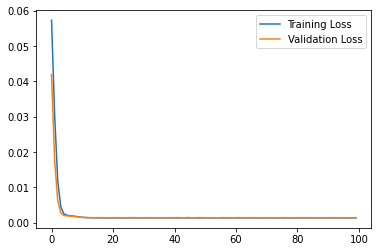

Processing fold #1
loss average:  0.002400988333392888
val_loss average:  0.0018508605065289884


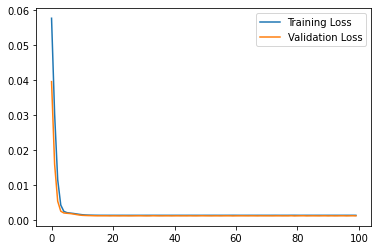

Processing fold #2
loss average:  0.002309108969056979
val_loss average:  0.0021934369148220866


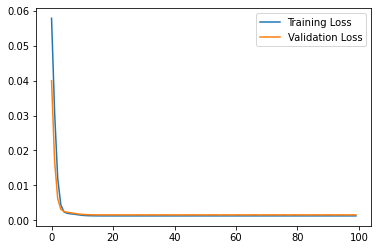

Processing fold #3
loss average:  0.00236639091395773
val_loss average:  0.0020628093951381744


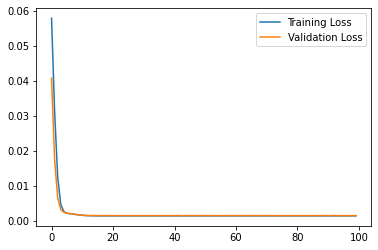

In [16]:
'''
K-fold validation
'''
X = x_train
y = x_train

k = 4
num_val_samples = len(X) // k

num_epochs = 100
all_scores = []

all_mse_histories = []
all_val_mse_histories = []
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [X[:i * num_val_samples],
            X[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y[:i * num_val_samples],
            y[(i + 1) * num_val_samples:]],
        axis=0)
    autoencoder = Autoencoder(latent_dim=64 * 2)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    history = autoencoder.fit(partial_train_data, partial_train_targets,
						#shuffle=True,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    #mae_history = history.history["val_mae"]
    #all_mae_histories.append(mae_history)
    # Fold별 그래프 표시하기 위해 추가함
    # plt.plot(range(1, len(mae_history) + 1), mae_history)
    # plt.xlabel("Epochs")
    # plt.ylabel("Validation MAE")
    # #plt.ylim([0, 0.30])
    # plt.show()

    mse_history = history.history["loss"]
    all_mse_histories.append(mse_history)
    print("loss average: ", np.mean(mse_history))
    
    val_mse_history = history.history["val_loss"]
    all_val_mse_histories.append(val_mse_history)
    print("val_loss average: ", np.mean(val_mse_history))

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    #plt.ylim([0, 0.150])
    plt.show()


In [17]:
# all_mse_histories

In [18]:
print("all loss average: ", np.mean(all_mse_histories))
print("all val loss average: ", np.mean(all_val_mse_histories))


all loss average:  0.0023591890261741356
all val loss average:  0.0020383139775367455


In [19]:
# Building the history of successive mean K-fold validation scores
average_mse_history = [
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)]
average_val_mse_history = [
    np.mean([x[i] for x in all_val_mse_histories]) for i in range(num_epochs)]    

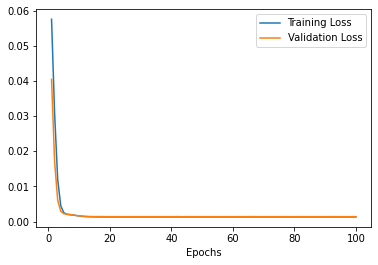

In [21]:
# Plotting validation scores
plt.plot(range(1, len(average_mse_history) + 1), average_mse_history, label="Training Loss")
plt.plot(range(1, len(average_val_mse_history) + 1), average_val_mse_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
# plt.ylim([0, 0.15])
plt.show()